In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from scipy import integrate
import sys
sys.path.append('../../scripts/')
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24)

In [14]:
# Data and plot parameters
methods = ['tejaas_rr', 'tejaas_jpa', 'matrixeqtl']
ncfs = [10, 20, 30]
cfstds = [0.4, 0.6, 0.8, 1.0]
srcdir = '/cbscratch/sbanerj/trans-eqtl/simulation/confounder_strength'

#### AUC where FPR < 0.1
# fprcut = 0.1
# ymax = 0.1
# yshift = 0.0
# ymajorticks = [0.0, 0.05, 0.1]
# yminorticks = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
# data_csv_file = "simulation_confounding_auc01_comparison.txt"
# plot_out_file = "../plots/simulation_confounding_auc01_comparison.png"

#### Full AUC
fprcut = 1.0
ymax = 1.0
yshift = 0.5
ymajorticks = [0.6, 0.8, 1.0]
yminorticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
data_csv_file = "simulation_confounding_auc_comparison.txt"
plot_out_file = "../plots/simulation_confounding_auc_comparison.png"


methodcolors = {'tejaas_rr':  '#cc3129ff',
                'tejaas_jpa': '#ff8680ff',
                'matrixeqtl': '#209E2FFF',
                'matrixeqtl_fdr': '#1fcc80ff'}

methodlabels = {'tejaas_rr': 'RevReg',
                'tejaas_jpa': 'JPA',
                'matrixeqtl': 'MatrixEQTL'}

In [15]:
data  = dict()
errup = dict()
errdn = dict()
for method in methods:
    data[method]  = dict()
    errup[method] = dict()
    errdn[method] = dict()
    for ncf in ncfs:
        data[method][ncf]  = dict()
        errup[method][ncf] = dict()
        errdn[method][ncf] = dict()
        for cfstd in cfstds:
            simdir = "12639_450_{:d}_800_30_100_100_0.01_0.5_0.0_{:03.1f}_0.6_4.0_0.1_20_0.02".format(ncf, cfstd)
            if method == 'tejaas_rr':
                rocfile = os.path.join(srcdir, simdir, 'rocdata/tejaas_permnull_sb0.2_raw_knn30_peer0_fpr_tpr.txt')
            elif method == 'tejaas_jpa':
                rocfile = os.path.join(srcdir, simdir, 'rocdata/jpa_qn_cclm_peer0_fpr_tpr.txt')
            elif method == 'matrixeqtl':
                rocfile = os.path.join(srcdir, simdir, 'rocdata/matrixeqtl_qn_cclm_peer0_fpr_tpr.txt')
                
            success = False
            if os.path.exists(rocfile):
                roc = np.loadtxt(rocfile, skiprows=1)
                xx = roc[:, 0]
                yy = roc[:, 1]
                ystd = roc[:, 2]
                idx = np.where(xx <= fprcut)[0]
                if idx.shape[0] > 5:
                    auc = integrate.simps(yy[idx], xx[idx])
                    aucup = integrate.simps(yy[idx] + ystd[idx], xx[idx])
                    aucdn = integrate.simps(yy[idx] - ystd[idx], xx[idx])
                    data[method][ncf][cfstd]  = auc
                    errup[method][ncf][cfstd] = aucup
                    errdn[method][ncf][cfstd] = aucdn
                    success = True
            if not success:
                yrand = np.linspace(0, fprcut, 100)
                auc = integrate.simps(yrand, yrand)
                data[method][ncf][cfstd] = auc
                errup[method][ncf][cfstd] = auc
                errdn[method][ncf][cfstd] = auc

In [16]:
def single_barplot(ax, yvals, ymax, yerr, methodcolors, errcolors, ymajorticks, yminorticks, yshift,
                   xlabel, ylabel, showyaxis, showxlabel, showylabel, showerror):
    
    nbar = len(yvals)

    ax.set_yticks([y - yshift for y in ymajorticks])
    ax.set_yticks([y - yshift for y in yminorticks], minor=True)
    ax.tick_params(bottom = False, top = False, left = False, right = False, labelleft = False, labelbottom = False)
    ax.grid(which = 'both', axis = 'y', linestyle = 'dotted', zorder = 0)
    
    ind = np.arange(1, nbar + 1)
    ax.bar(ind, [y - yshift for y in yvals], color = methodcolors, linewidth = 0, width = 0.8, zorder = 10)
    
    # Errorbars done separately. The one included in bar() method mess up the zorder
    if showerror:
        for i in range(nbar):
            errmin = yvals[i] - yerr[i] - yshift
            errmax = yvals[i] + yerr[i] - yshift
            ax.plot([ind[i], ind[i]], [errmin, errmax], color = errcolors[i], zorder = 20)

    
    if showyaxis: 
        ax.tick_params(which = 'major', right = True, labelright = True)
        yticks = ax.get_yticks(minor = False)
        yticklabels = ['{:2.2f}'.format(y + yshift) for y in yticks]
        ax.set_yticklabels(yticklabels, minor = False)

    if showylabel:
        ax.set_ylabel(ylabel)
        ax.yaxis.set_label_position("right")
        
    if showxlabel:
        ax.set_xlabel(xlabel)
        
    for side, border in ax.spines.items():
        if not side == 'bottom':
            border.set_visible(False)
        if showyaxis and side == 'right':
            border.set_visible(True)

    ax.set_ylim([-0.01, ymax - yshift])
    ax.set_xlim([0, nbar + 1])
    ax.set_facecolor('None')
    
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent + 0.5 * (width - height)
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

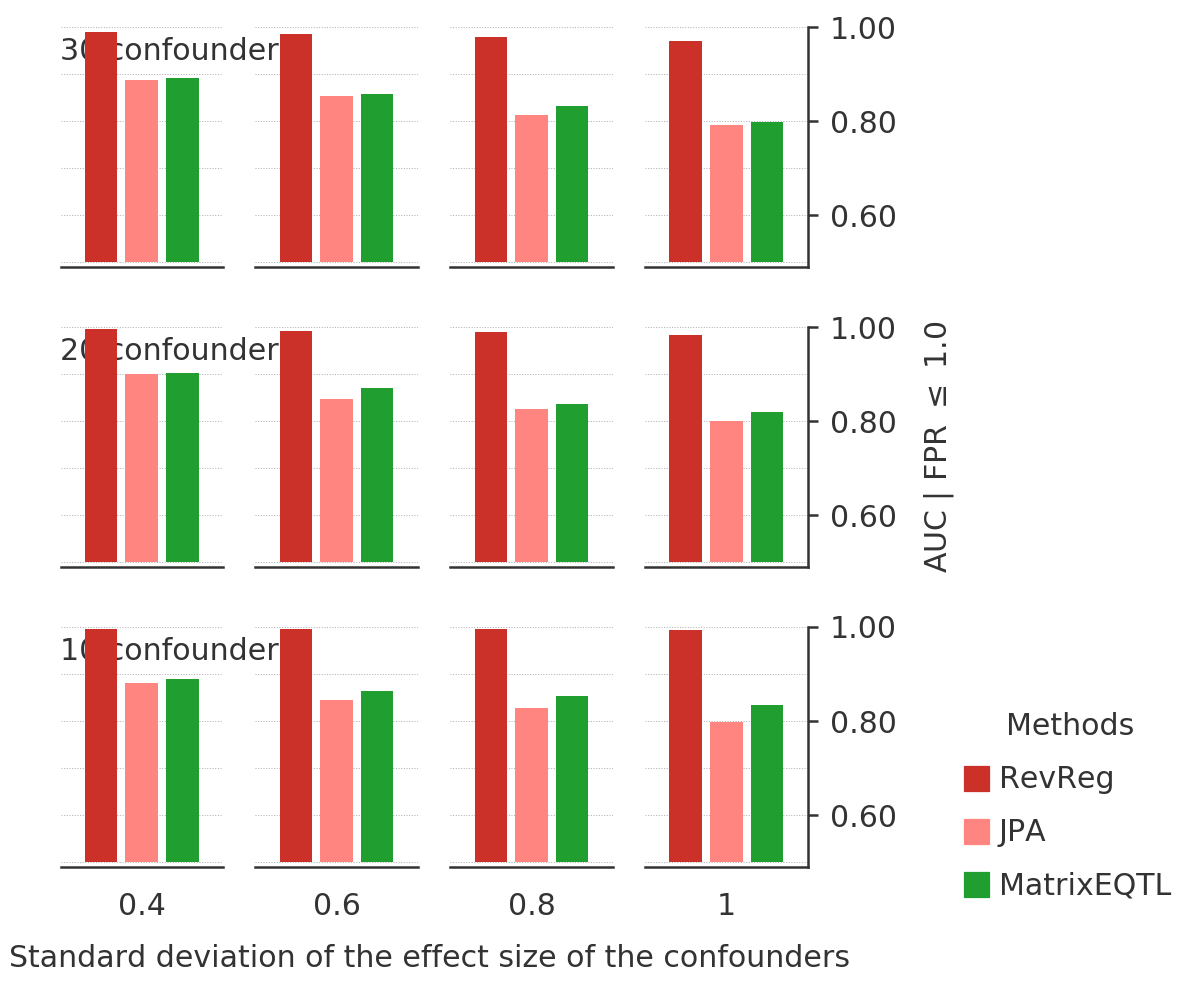

In [17]:
nrow = max([len(vals) for m, vals in data.items()])
ncol = max([len(val2) for m, val1 in data.items() for ncf, val2 in val1.items()])

rownames = [None for x in range(nrow)]
colnames = [None for x in range(ncol)]
yvals = [dict() for x in range(nrow * ncol)]
yerrs = [dict() for x in range(nrow * ncol)]


for method in methods:
    methodvals = data[method]
    for irow, ncfvals in enumerate(methodvals.items()):
        rownames[irow] = ncfvals[0]
        for icol, values in enumerate(ncfvals[1].items()):
            colnames[icol] = values[0]
            index = irow * ncol + icol
            yvals[index][method] = values[1]
            yerrs[index][method] = errup[method][ncfvals[0]][values[0]] - errdn[method][ncfvals[0]][values[0]]
            
fig = plt.figure(figsize = (10, 10))
bgcolor = 'white'
#bgcolor = 'cornsilk'
ylabel = "AUC | FPR $\leq$ {:03.1f}".format(fprcut)
mcolors = [methodcolors[x] for x in methods]
ecolors = ['#333333' for x in methods]
showerror = False

gs = [None for x in range(nrow)]
ax = [None for x in range(nrow * ncol)]

hspacefrac = 0.05
bottompos = [i * (1 / nrow) for i in range(nrow)]
toppos = [bottompos[i] + ( (1 - hspacefrac) / nrow) for i in range(nrow)]

for irow in range(nrow):
    rowtext =  '{:d} confounders'.format(rownames[irow])
    bg_gs = gridspec.GridSpec(1, 1, figure = fig, left = 0, right = 1,
                              bottom = bottompos[irow], top = toppos[irow],
                              hspace = 0, wspace = 0)
    bg_ax = fig.add_subplot(bg_gs[0])
    bg_ax.set_facecolor(bgcolor)
    for side, border in bg_ax.spines.items():
        border.set_visible(False)
    bg_ax.tick_params(bottom = False, top = False, left = False, right = False, 
                   labelleft = False, labelbottom = False)
    bg_ax.text(0.02, 0.82, rowtext)
    if irow == 0:
        bg_ax.set_xlabel('Standard deviation of the effect size of the confounders', labelpad = 40, x = 0.43)
    
    gs[irow] = gridspec.GridSpec(1, ncol, figure = fig, 
                                 left = 0.02, right = 0.85, 
                                 bottom = bottompos[irow] + 0.03, top = toppos[irow] - 0.02, 
                                 wspace = 0.2)
    showxlabel = False
    if irow == 0: showxlabel = True
    for icol in range(ncol):
        xlabel = '{:g}'.format(colnames[icol])
        idx = irow * ncol + icol
        ax[idx] = fig.add_subplot(gs[irow][icol])
        y = [val for key, val in yvals[idx].items()]
        yerr = [val for key, val in yerrs[idx].items()]
        showyaxis = False
        if icol == ncol - 1: showyaxis = True
        showylabel = False
        if icol == ncol - 1 and irow == 1: showylabel = True
        single_barplot(ax[idx], y, ymax, yerr, mcolors, ecolors, 
                       ymajorticks, yminorticks, yshift,
                       xlabel, ylabel, showyaxis, showxlabel, showylabel, showerror)
        
legendtitle = 'Methods'
mhandles = [mpatches.Rectangle((0,0), 20, 20, **{'color': methodcolors[x]}) for x in methods]
mlabels = [methodlabels[x] for x in methods]
mhandler_map = dict()
for x in mhandles:
    mhandler_map[x] = HandlerSquare()
legend = ax[3].legend(handles = mhandles, labels = mlabels, handler_map = mhandler_map,
                      loc = 'lower left', bbox_to_anchor = (1.9, -0.2), frameon = True, title = legendtitle)
lframe = legend.get_frame()
#lframe.set_facecolor(bgcolor)
lframe.set_linewidth(0)

plt.savefig(plot_out_file, bbox_inches='tight')
plt.show()

### Create a pandas dataframe

In [18]:
import pandas as pd

functions = list()
for ncf in ncfs:
    for cfstd in cfstds:
        functions.append(f'{ncf};{cfstd}')
        
colnames = methods + [f'{x}_errup' for x in methods] + [f'{x}_errdn' for x in methods]

datadf = pd.DataFrame(index=functions, columns=colnames)
for fn in datadf.index:
    ncf = int(fn.split(';')[0].strip())
    cfstd = float(fn.split(';')[1].strip())
    fndata = [data[x][ncf][cfstd] for x in methods] + \
             [errup[x][ncf][cfstd] for x in methods] + \
             [errdn[x][ncf][cfstd] for x in methods]
    datadf.loc[fn] = fndata
    
datadf.to_csv(data_csv_file)
datadf

,tejaas_rr,tejaas_jpa,matrixeqtl,tejaas_rr_errup,tejaas_jpa_errup,matrixeqtl_errup,tejaas_rr_errdn,tejaas_jpa_errdn,matrixeqtl_errdn
10;0.4,0.996642,0.881683,0.889939,1.00056,0.929249,0.941923,0.992721,0.834116,0.837955
10;0.6,0.994992,0.844595,0.864584,1.00239,0.895208,0.925016,0.987596,0.793983,0.804152
10;0.8,0.995352,0.826896,0.853668,1.00091,0.878907,0.907086,0.989793,0.774884,0.80025
10;1.0,0.99364,0.797333,0.83373,0.999943,0.847178,0.889933,0.987338,0.747488,0.777528
20;0.4,0.995481,0.89952,0.901877,0.999688,0.935608,0.938473,0.991274,0.863432,0.865281
20;0.6,0.992284,0.846315,0.871062,0.997687,0.893412,0.91404,0.98688,0.799218,0.828083
20;0.8,0.989504,0.825315,0.837018,0.997071,0.869075,0.894245,0.981937,0.781555,0.779791
20;1.0,0.982685,0.800966,0.820066,0.99709,0.844899,0.873433,0.96828,0.757032,0.766699
30;0.4,0.989818,0.887944,0.891598,0.997575,0.934225,0.938336,0.98206,0.841663,0.844861
30;0.6,0.985135,0.853411,0.858097,0.997351,0.906323,0.919344,0.972918,0.8005,0.796849
